# Image features exercise
Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the assignments page on the course website.

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.



In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'C:\\Users\sweetheart\Desktop\jupyter work\cs231n\datasets\cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

# Extract Features
For each image we will compute a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space. We form our final feature vector for each image by concatenating the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring color information, and the color histogram represents the color of the input image while ignoring texture. As a result, we expect that using both together ought to work better than using either alone. Verifying this assumption would be a good thing to try for the bonus section.

The hog_feature and color_histogram_hsv functions both operate on a single image and return a feature vector for that image. The extract_features function takes a set of images and a list of feature functions and evaluates each feature function on each image, storing the results in a matrix where each column is the concatenation of all feature vectors for a single image.

Для каждого изображения мы будем вычислять гистограмму ориентированных градиентов (HOG), а также цветовую гистограмму с использованием тонального канала в цветовом пространстве HSV. Мы формируем наш конечный вектор признаков для каждого изображения путем конкатенации векторов признаков HOG и цветовой гистограммы.

Грубо говоря, HOG должен фиксировать текстуру изображения, игнорируя информацию о цвете, а гистограмма цвета представляет цвет входного изображения при игнорировании текстуры. В результате мы ожидаем, что использование обоих вместе должно работать лучше, чем использование в одиночку. Проверка этого предположения было бы неплохо попробовать в разделе бонусов.

Функции hog_feature и color_histogram_hsv работают с одним изображением и возвращают вектор объекта для этого изображения. Функция extract_features принимает набор изображений и список функций функций и оценивает каждую функцию функции на каждом изображении, сохраняя результаты в матрице, где каждый столбец является конкатенацией всех векторов признаков для одного изображения.

In [15]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

# Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
from tqdm import tqdm_notebook

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        svm = LinearSVM()
        _ = svm.train(X_train_feats, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.092388 val accuracy: 0.083000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.107633 val accuracy: 0.117000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.413143 val accuracy: 0.409000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.102143 val accuracy: 0.102000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.411755 val accuracy: 0.415000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.412000 val accuracy: 0.426000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415020 val accuracy: 0.413000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.417837 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.327306 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.426000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


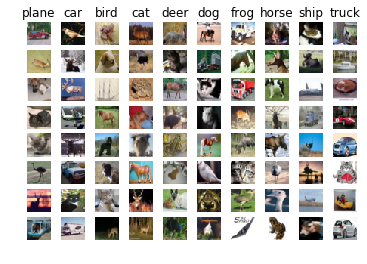

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

# Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Опишите результаты ошибочной классификации, которые вы видите. Имеют ли они смысл?

Ошибки, допущенные алгоритмом, часто ясны и могут иметь объяснение: грузовики часто классифицируются как автомобили, олени смешиваются с собаками и так далее.



# Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

# Нейронная сеть для функций изображения
Ранее в этом приближении мы видели, что обучение двухслойной нейронной сети на необработанных пикселях обеспечило лучшую эффективность классификации, чем линейные классификаторы на необработанных пикселях. В этом ноутбуке мы видели, что линейные классификаторы на объектах изображений превосходят линейные классификаторы на необработанных пикселях.

Для полноты мы также должны попытаться обучить нейронную сеть функциям изображения. Такой подход должен превзойти все предыдущие подходы: вы должны легко получить более 55% точности классификации на тестовом наборе; наша лучшая модель достигает около 60% точности классификации.

In [8]:
print(X_train_feats.shape)

(49000, 155)


In [10]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
results = {}
best_val_acc = -1
learning_rates = np.linspace(1e-1, 1, 5)
regularization_strengths = np.linspace(1e-4, 1e-3, 3)
hidden_sizes = [300, 400, 500]

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_params = None
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        for hidden_size in tqdm_notebook(hidden_sizes):
            print('lr: {}, reg: {}, hidden size: {}'.format(lr, reg, hidden_size))
            net = TwoLayerNet(input_dim, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=False)
            y_train_pred = net.predict(X_train_feats)
            train_acc = np.mean(y_train == y_train_pred)

            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            results[(lr, reg, hidden_size)] = val_acc
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net   
                best_params = (lr, reg, hidden_size)
################################################################################
#                              END OF YOUR CODE                                #
###############################################################################

lr: 0.1, reg: 0.0001, hidden size: 300
Validation accuracy:  0.528
lr: 0.1, reg: 0.0001, hidden size: 400
Validation accuracy:  0.53
lr: 0.1, reg: 0.0001, hidden size: 500
Validation accuracy:  0.531


lr: 0.1, reg: 0.00055, hidden size: 300
Validation accuracy:  0.528
lr: 0.1, reg: 0.00055, hidden size: 400
Validation accuracy:  0.524
lr: 0.1, reg: 0.00055, hidden size: 500
Validation accuracy:  0.525


lr: 0.1, reg: 0.001, hidden size: 300
Validation accuracy:  0.515
lr: 0.1, reg: 0.001, hidden size: 400
Validation accuracy:  0.528
lr: 0.1, reg: 0.001, hidden size: 500
Validation accuracy:  0.509


lr: 0.325, reg: 0.0001, hidden size: 300
Validation accuracy:  0.576
lr: 0.325, reg: 0.0001, hidden size: 400
Validation accuracy:  0.587
lr: 0.325, reg: 0.0001, hidden size: 500
Validation accuracy:  0.575


lr: 0.325, reg: 0.00055, hidden size: 300
Validation accuracy:  0.578
lr: 0.325, reg: 0.00055, hidden size: 400
Validation accuracy:  0.571
lr: 0.325, reg: 0.00055, hidden size: 500
Validation accuracy:  0.588


lr: 0.325, reg: 0.001, hidden size: 300
Validation accuracy:  0.573
lr: 0.325, reg: 0.001, hidden size: 400
Validation accuracy:  0.581
lr: 0.325, reg: 0.001, hidden size: 500
Validation accuracy:  0.582


lr: 0.55, reg: 0.0001, hidden size: 300
Validation accuracy:  0.586
lr: 0.55, reg: 0.0001, hidden size: 400
Validation accuracy:  0.6
lr: 0.55, reg: 0.0001, hidden size: 500
Validation accuracy:  0.611


lr: 0.55, reg: 0.00055, hidden size: 300
Validation accuracy:  0.578
lr: 0.55, reg: 0.00055, hidden size: 400
Validation accuracy:  0.594
lr: 0.55, reg: 0.00055, hidden size: 500
Validation accuracy:  0.581


lr: 0.55, reg: 0.001, hidden size: 300
Validation accuracy:  0.58
lr: 0.55, reg: 0.001, hidden size: 400
Validation accuracy:  0.587
lr: 0.55, reg: 0.001, hidden size: 500
Validation accuracy:  0.58


lr: 0.775, reg: 0.0001, hidden size: 300
Validation accuracy:  0.568
lr: 0.775, reg: 0.0001, hidden size: 400
Validation accuracy:  0.591
lr: 0.775, reg: 0.0001, hidden size: 500
Validation accuracy:  0.576


lr: 0.775, reg: 0.00055, hidden size: 300
Validation accuracy:  0.573
lr: 0.775, reg: 0.00055, hidden size: 400
Validation accuracy:  0.577
lr: 0.775, reg: 0.00055, hidden size: 500
Validation accuracy:  0.59


lr: 0.775, reg: 0.001, hidden size: 300
Validation accuracy:  0.585
lr: 0.775, reg: 0.001, hidden size: 400
Validation accuracy:  0.593
lr: 0.775, reg: 0.001, hidden size: 500
Validation accuracy:  0.566


lr: 1.0, reg: 0.0001, hidden size: 300
Validation accuracy:  0.565
lr: 1.0, reg: 0.0001, hidden size: 400
Validation accuracy:  0.564
lr: 1.0, reg: 0.0001, hidden size: 500
Validation accuracy:  0.563


lr: 1.0, reg: 0.00055, hidden size: 300
Validation accuracy:  0.585
lr: 1.0, reg: 0.00055, hidden size: 400
Validation accuracy:  0.587
lr: 1.0, reg: 0.00055, hidden size: 500
Validation accuracy:  0.599


lr: 1.0, reg: 0.001, hidden size: 300
Validation accuracy:  0.58
lr: 1.0, reg: 0.001, hidden size: 400
Validation accuracy:  0.581
lr: 1.0, reg: 0.001, hidden size: 500
Validation accuracy:  0.593



In [11]:
best_params

(0.55, 0.0001, 500)

In [12]:
best_net = TwoLayerNet(input_dim, best_params[2], num_classes)
stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=5000, batch_size=200,
            learning_rate=best_params[0], learning_rate_decay=0.95,
            reg=best_params[1], verbose=True)

iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.462593
iteration 200 / 5000: loss 1.332039
iteration 300 / 5000: loss 1.386235
iteration 400 / 5000: loss 1.277100
iteration 500 / 5000: loss 1.226669
iteration 600 / 5000: loss 1.217212
iteration 700 / 5000: loss 1.086535
iteration 800 / 5000: loss 1.121889
iteration 900 / 5000: loss 1.114567
iteration 1000 / 5000: loss 1.029610
iteration 1100 / 5000: loss 0.958819
iteration 1200 / 5000: loss 0.963584
iteration 1300 / 5000: loss 0.826685
iteration 1400 / 5000: loss 0.775005
iteration 1500 / 5000: loss 0.975527
iteration 1600 / 5000: loss 0.885407
iteration 1700 / 5000: loss 0.914848
iteration 1800 / 5000: loss 0.828108
iteration 1900 / 5000: loss 0.927846
iteration 2000 / 5000: loss 0.913053
iteration 2100 / 5000: loss 0.769297
iteration 2200 / 5000: loss 0.892574
iteration 2300 / 5000: loss 0.671604
iteration 2400 / 5000: loss 0.810612
iteration 2500 / 5000: loss 0.773613
iteration 2600 / 5000: loss 0.696739
iteration 270

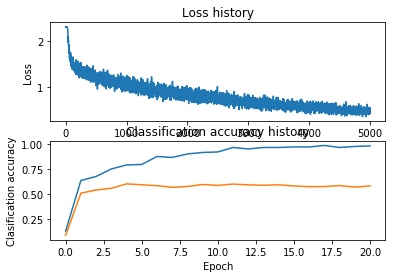

In [13]:

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [14]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.583
